Setup & installation

In [1]:
!pip install -q gymnasium[classic-control] torch matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00


Import & configuration

In [2]:
import math, random
from collections import deque

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


Replay Buffer

In [3]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)
    def __len__(self):
        return len(self.buffer)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        import torch
        return (
            torch.tensor(state, dtype=torch.float32, device=device),
            torch.tensor(action, dtype=torch.int64, device=device).unsqueeze(-1),
            torch.tensor(reward, dtype=torch.float32, device=device).unsqueeze(-1),
            torch.tensor(next_state, dtype=torch.float32, device=device),
            torch.tensor(done, dtype=torch.float32, device=device).unsqueeze(-1),
        )


Q‑Network (PyTorch)

In [4]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, action_dim),
        )
    def forward(self, x):
        return self.net(x)


Agent DQN (epsilon‑greedy + target network)

In [5]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-3,
                 epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=50000):
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay  # dalam total langkah (steps)
        self.total_steps = 0

        self.q = QNetwork(state_dim, action_dim).to(device)
        self.q_target = QNetwork(state_dim, action_dim).to(device)
        self.q_target.load_state_dict(self.q.state_dict())

        self.optim = optim.Adam(self.q.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.action_dim = action_dim

    def epsilon(self):
        # linear-ish decay
        eps = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * max(
            0.0, (self.epsilon_decay - self.total_steps)/self.epsilon_decay
        )
        return float(eps)

    def select_action(self, state):
        if random.random() < self.epsilon():
            return random.randrange(self.action_dim)
        with torch.no_grad():
            s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            return int(torch.argmax(self.q(s), dim=1).item())

    def train_step(self, batch, gamma, tau=0.005):
        states, actions, rewards, next_states, dones = batch
        q_values = self.q(states).gather(1, actions)
        with torch.no_grad():
            max_next_q = self.q_target(next_states).max(1, keepdim=True)[0]
            targets = rewards + gamma * max_next_q * (1.0 - dones)
        loss = self.loss_fn(q_values, targets)
        self.optim.zero_grad(); loss.backward(); self.optim.step()

        # soft update target
        for tp, p in zip(self.q_target.parameters(), self.q.parameters()):
            tp.data.copy_(tau * p.data + (1.0 - tau) * tp.data)
        return loss.item()


Environment & hyperparameter

In [6]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]   # 4
action_dim = env.action_space.n              # 2

agent = DQNAgent(
    state_dim=state_dim, action_dim=action_dim,
    gamma=0.99, lr=1e-3,
    epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=50_000
)

buffer = ReplayBuffer(capacity=100_000)
BATCH_SIZE = 64
TRAIN_START = 1_000
MAX_EPISODES = 500
MAX_STEPS_PER_EP = 1000
SOFT_TAU = 0.005

reward_history, loss_history = [], []


Training loop + plot

Episode   10 | AvgReward(10)=  17.20 | Epsilon=0.997 | Buffer=172
Episode   20 | AvgReward(10)=  21.90 | Epsilon=0.993 | Buffer=391
Episode   30 | AvgReward(10)=  15.30 | Epsilon=0.990 | Buffer=544
Episode   40 | AvgReward(10)=  26.60 | Epsilon=0.985 | Buffer=810
Episode   50 | AvgReward(10)=  26.90 | Epsilon=0.979 | Buffer=1079
Episode   60 | AvgReward(10)=  19.50 | Epsilon=0.976 | Buffer=1274
Episode   70 | AvgReward(10)=  21.30 | Epsilon=0.972 | Buffer=1487
Episode   80 | AvgReward(10)=  24.50 | Epsilon=0.967 | Buffer=1732
Episode   90 | AvgReward(10)=  19.80 | Epsilon=0.963 | Buffer=1930
Episode  100 | AvgReward(10)=  23.10 | Epsilon=0.959 | Buffer=2161
Episode  110 | AvgReward(10)=  21.00 | Epsilon=0.955 | Buffer=2371
Episode  120 | AvgReward(10)=  25.70 | Epsilon=0.950 | Buffer=2628
Episode  130 | AvgReward(10)=  28.60 | Epsilon=0.945 | Buffer=2914
Episode  140 | AvgReward(10)=  28.10 | Epsilon=0.939 | Buffer=3195
Episode  150 | AvgReward(10)=  29.70 | Epsilon=0.934 | Buffer=3492

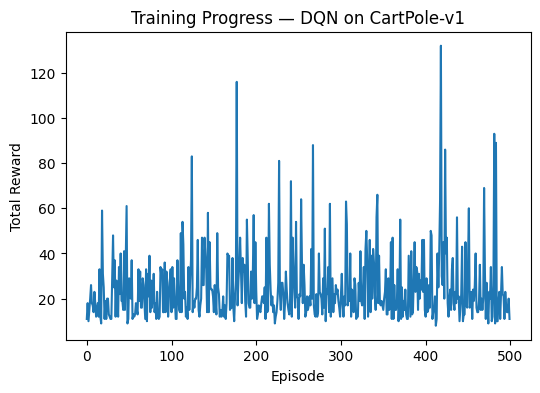

In [7]:
best_avg_reward = -float('inf')
global_step = 0

for ep in range(1, MAX_EPISODES + 1):
    state, info = env.reset(seed=SEED + ep)
    ep_reward = 0.0

    for t in range(MAX_STEPS_PER_EP):
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        buffer.push(state, action, reward, next_state, done)
        state = next_state
        ep_reward += reward
        agent.total_steps += 1
        global_step += 1

        if len(buffer) >= TRAIN_START:
            batch = buffer.sample(BATCH_SIZE)
            loss = agent.train_step(batch, gamma=agent.gamma, tau=SOFT_TAU)
            loss_history.append(loss)

        if done:
            break

    reward_history.append(ep_reward)
    if ep % 10 == 0:
        last10 = reward_history[-10:]
        avg10 = sum(last10)/len(last10)
        best_avg_reward = max(best_avg_reward, avg10)
        print(f"Episode {ep:4d} | AvgReward(10)={avg10:7.2f} | Epsilon={agent.epsilon():.3f} | Buffer={len(buffer)}")

# Plot total reward per episode
plt.figure(figsize=(6,4))
plt.plot(reward_history)
plt.xlabel("Episode"); plt.ylabel("Total Reward"); plt.title("Training Progress — DQN on CartPole-v1")
plt.show()


Evaluation

In [8]:
def evaluate(env, agent, episodes=10):
    scores = []
    for ep in range(episodes):
        state, info = env.reset(seed=SEED + 1000 + ep)
        total = 0.0; done = False
        while not done:
            with torch.no_grad():
                s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                action = int(torch.argmax(agent.q(s), dim=1).item())
            state, reward, terminated, truncated, info = env.step(action)
            total += reward
            done = terminated or truncated
        scores.append(total)
    import numpy as np
    return float(np.mean(scores)), float(np.std(scores))

avg, std = evaluate(env, agent, episodes=10)
print(f"Average reward over 10 eval episodes: {avg:.2f} ± {std:.2f}")


Average reward over 10 eval episodes: 106.90 ± 3.94


Saving model

In [9]:
MODEL_PATH = "dqn_cartpole.pt"
torch.save(agent.q.state_dict(), MODEL_PATH)
print("Model disimpan ke:", MODEL_PATH)


Model disimpan ke: dqn_cartpole.pt


Inference & demo play (deterministic)

In [10]:
# !pip install -q gymnasium[classic-control] torch numpy matplotlib  # jalankan jika belum terpasang

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "dqn_cartpole.pt"   # ganti jika path beda
SEED = 42

# --- Q-Network (harus sama arsitekturnya dengan saat training) ---
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, action_dim),
        )
    def forward(self, x):
        return self.net(x)

# --- Load env & model ---
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]  # 4
action_dim = env.action_space.n             # 2

q = QNetwork(state_dim, action_dim).to(DEVICE)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
q.load_state_dict(state_dict)
q.eval()

# --- Helper: pilih aksi secara greedy (tanpa eksplorasi) ---
@torch.no_grad()
def select_action(state_np):
    s = torch.tensor(state_np, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    q_vals = q(s)
    return int(torch.argmax(q_vals, dim=1).item())

# --- Main demo: jalankan beberapa episode dan cetak skor ---
def play(n_episodes=5, max_steps=1000):
    scores = []
    for ep in range(n_episodes):
        state, info = env.reset(seed=SEED + ep)
        total = 0.0
        for t in range(max_steps):
            action = select_action(state)
            state, reward, terminated, truncated, info = env.step(action)
            total += reward
            if terminated or truncated:
                break
        scores.append(total)
        print(f"Episode {ep+1}/{n_episodes} — Score: {total:.0f}")
    print(f"Rata-rata skor: {np.mean(scores):.2f} ± {np.std(scores):.2f}")
    return scores

scores = play(n_episodes=10)


Episode 1/10 — Score: 111
Episode 2/10 — Score: 100
Episode 3/10 — Score: 107
Episode 4/10 — Score: 112
Episode 5/10 — Score: 102
Episode 6/10 — Score: 106
Episode 7/10 — Score: 108
Episode 8/10 — Score: 104
Episode 9/10 — Score: 112
Episode 10/10 — Score: 102
Rata-rata skor: 106.40 ± 4.15


Save MP4 video of one episode

In [11]:
# !pip install -q gymnasium[classic-control] imageio imageio-ffmpeg

import os, shutil
from gymnasium.wrappers import RecordVideo

# Bersihkan folder video lama (opsional)
if os.path.exists("videos"):
    shutil.rmtree("videos")

venv = RecordVideo(
    gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder="videos",
    episode_trigger=lambda e: True  # rekam semua episode
)

state, info = venv.reset(seed=SEED + 999)
done = False
total = 0.0
while not done:
    action = select_action(state)
    state, reward, terminated, truncated, info = venv.step(action)
    total += reward
    done = terminated or truncated
venv.close()
print("Selesai merekam. Cari file .mp4 di folder 'videos'.")

# (Di Colab) tampilkan video
try:
    import glob
    from IPython.display import HTML
    mp4s = sorted(glob.glob("videos/*.mp4"))
    print("Video:", mp4s[-1] if mp4s else "tidak ditemukan")
    if mp4s:
        HTML(f"""
        <video width="480" controls>
            <source src="{mp4s[-1]}" type="video/mp4">
        </video>
        """)
except Exception as e:
    print("Preview video opsional:", e)


Selesai merekam. Cari file .mp4 di folder 'videos'.
Video: videos/rl-video-episode-0.mp4
